Copyright Preferred Networks, Inc. and Preferred Computational Chemistry, Inc. as contributors to Matlantis contrib project

This notebook was machine translated from Japanese to English.

# Using Optuna for Adsorption Structure Search (Beginner Level)

In processes such as catalytic reactions, molecules adsorb onto the catalyst surface, react on the surface, and then the products desorb from the catalyst surface. In such processes, adsorption structures with molecules present on the surface are dealt with. [Section 3.3 of the Atomistic Simulation Tutorial](https://docs.matlantis.com/atomistic-simulation-tutorial/ja/3_3_slab_adsorption_energy.html) explained the adsorption energy in such processes. It was mentioned that the adsorption energy differs for each adsorption structure, so there exist stable and unstable ones among the adsorption structures.

So, what kind of structures are energetically stable adsorption structures? Also, how can we find such structures? This notebook explains that the search for stable adsorption structures can be formulated as a black-box optimization problem and can actually be searched using the black-box optimization software [Optuna](https://optuna.org/). 

In [1]:
# !pip install -U optuna
# !pip install -U pfp-api-client
#In addition, please install `pfcc_extras`.

First, let's import the necessary modules. 

In [2]:
import io
import os
import tempfile

from ase import Atoms
from ase.build import bulk, fcc111, molecule, add_adsorbate
from ase.constraints import ExpCellFilter, StrainFilter
from ase.io import write, read
from ase.io.jsonio import write_json, read_json
from ase.optimize import LBFGS, FIRE
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import optuna

import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode

from pfcc_extras.visualize.view import view_ngl

print(f"pfp_api_client: {pfp_api_client.__version__}")

# estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="latest")
estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_U0, model_version="v3.0.0")
calculator = ASECalculator(estimator)

Also, let's prepare a utility function for locally optimizing structures.

In [3]:
def get_opt_energy(atoms, fmax=0.001, opt_mode: str = "normal"):    
    atoms.set_calculator(calculator)
    if opt_mode == "scale":
        opt1 = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]), logfile=None)
    elif opt_mode == "all":
        opt1 = LBFGS(ExpCellFilter(atoms), logfile=None)
    else:
        opt1 = LBFGS(atoms, logfile=None)
    opt1.run(fmax=fmax)
    return atoms.get_total_energy()

## What is Optuna
What is Optuna
[Optuna](https://optuna.org/) is an open-source black-box optimization software mainly developed by Preferred Networks, Inc. It is used by many users both domestically and internationally, and can be widely utilized from hyperparameter optimization to recipe optimization for cooking. (Please see the transition of GitHub Stars in the figure below.) The development community is also active, with around 15 core developers and nearly 200 contributors as of June 2023.
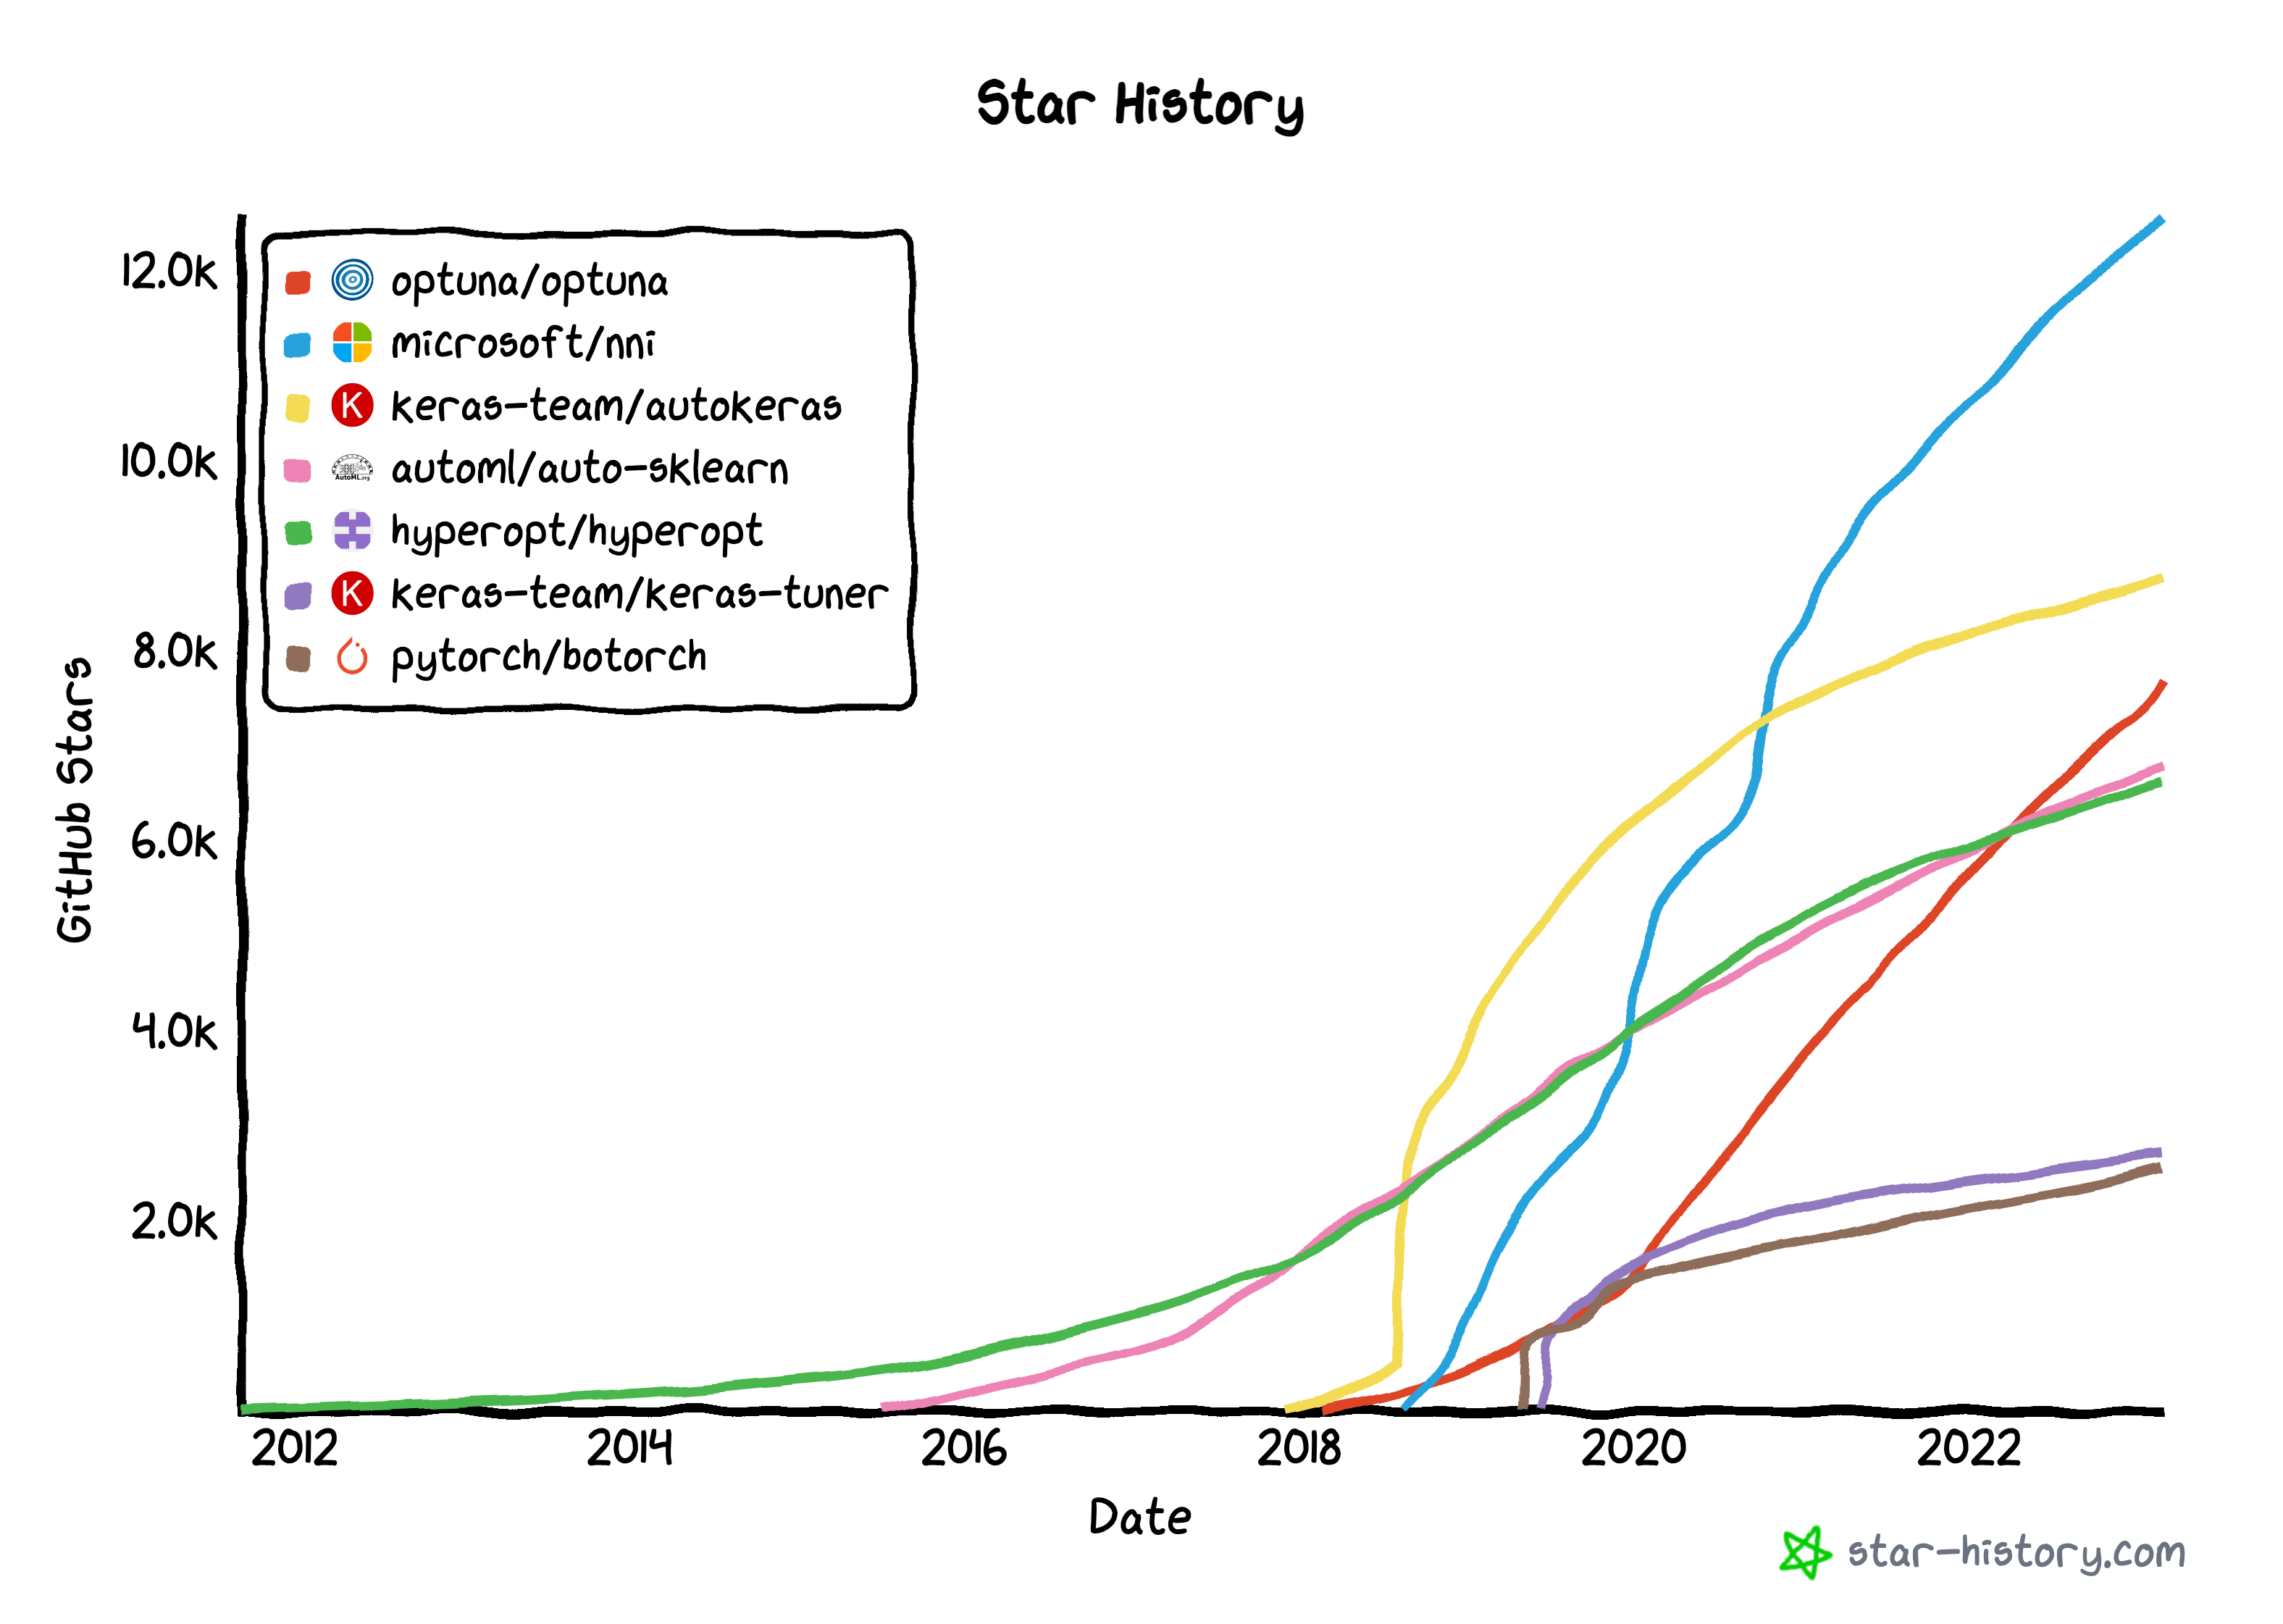

The usage is very simple; just define the objective function you want to optimize, create an object of the class called `Study`, and call its `optimize` method. 

In [4]:
# an esample to minimize y = x^2 (0 <= x <= 1)
def objective(trial):
    x = trial.suggest_float("x", 0, 1)
    return x ** 2

study = optuna.create_study()
study.optimize(objective, n_trials=30)
optuna.visualization.plot_optimization_history(study)

 This notebook shows through some simple examples that Optuna can be used to search for adsorption structures.

## Example: Adsorption Structure Search (Simple Version)

<!-- [Atomistic Simulation Tutorialの3.3節](https://docs.matlantis.com/atomistic-simulation-tutorial/ja/3_3_slab_adsorption_energy.html)では、吸着エネルギーの計算の例として、白金上の一酸化炭素分子の吸着反応を扱いました。
ここでは、全く同じ反応を対象として吸着構造の探索を行う例を示しましょう。 -->

[In Section 3.3 of the Atomistic Simulation Tutorial](https://docs.matlantis.com/atomistic-simulation-tutorial/ja/3_3_slab_adsorption_energy.html), the adsorption reaction of carbon monoxide molecules on platinum was used as an example of calculating adsorption energy. 
Here, let's show an example of searching for adsorption structures for the exact same reaction.

First, to create the adsorption structure we want to search for, we prepare the crystal (bulk) structure, surface (slab) structure, and the structure of the molecule to be adsorbed. For later use, each structure is locally optimized.

In [5]:
bulk_atoms = bulk("Pt", cubic=True)
bulk_atoms.calc = calculator
E_bulk = get_opt_energy(bulk_atoms, fmax=1e-4, opt_mode="scale")
E_bulk

-21.811600286477884

In [6]:
def create_slab():
    a = np.mean(np.diag(bulk_atoms.cell))
    slab =  fcc111("Pt", a=a, size=(4, 4, 4), vacuum=40.0, periodic=True)
    slab.calc = calculator
    E_slab = get_opt_energy(slab, fmax=1e-4, opt_mode="normal")
    return slab, E_slab 

slab, E_slab = create_slab()
view_ngl(slab, representations=["ball+stick"])

In [7]:
def create_mol():
    mol = molecule("CO")
    mol.calc = calculator
    E_mol = get_opt_energy(mol, fmax=1e-4)
    return mol, E_mol

mol, E_mol = create_mol()
view_ngl(mol, representations=["ball+stick"])

Now then, let's try adsorbing the created carbon monoxide molecule onto the platinum surface structure. It is not obvious which part of the surface structure the molecule adsorbs to. For the current surface structure, the following four adsorption sites are known as stable structures. They are:
 - `ontop`: above a single atom
 - `bridge`: between two atoms
 - `fcc`: between three atoms, at a position where there is no atom in the second layer
 - `hcp`: between three atoms, directly above an atom in the second layer

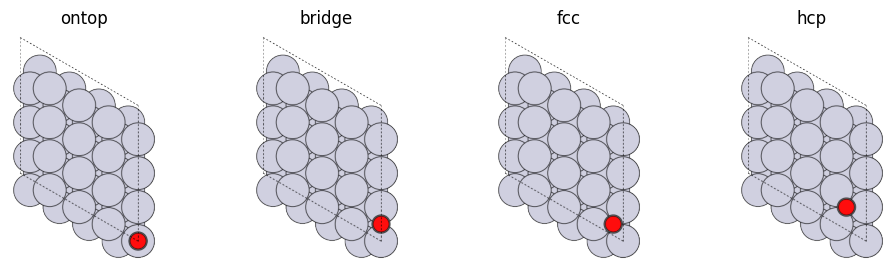

The search for adsorption structures using Optuna is performed as a sequential optimization. That is, in each trial (called a "trial" in black-box optimization), a single adsorption structure is selected, and the adsorption reaction is actually performed for that adsorption structure. The adsorption energy is calculated for each selected adsorption structure, and the selection of the adsorption structure is performed so that the calculated adsorption energy becomes as small as possible. In this way, the objective function is to select the adsorption structure, calculate its adsorption energy, and return the calculated energy, and Optuna is used to minimize this function.

The code to execute this is shown below. The function named `objective` represents the objective function for the optimization, and it causes the adsorption reaction by specifying the adsorption site obtained using Optuna's `Trial` object (here, it selects from the four strings of `ontop`, `bridge`, `fcc`, and `hcp`) for the created surface structure and molecular structure (`add_adsorbate` function). Finally, it locally optimizes the obtained adsorption structure and returns the adsorption energy. This objective function is passed to the `optimize` method of Optuna's `Study` object (which represents a single optimization consisting of a series of trials), and the optimization is executed. 

In [8]:
def objective(trial):
    slab, E_slab = create_slab()
    mol, E_mol = create_mol()
    
    site = trial.suggest_categorical("site", ["ontop", "bridge", "fcc", "hcp"])
    add_adsorbate(slab, mol, 3.0, site)
    E_slab_mol = get_opt_energy(slab, fmax=1e-3)

    return E_slab_mol - E_slab - E_mol

study = optuna.create_study()
study.optimize(objective, n_trials=30)
print(f"Best trial is #{study.best_trial.number}")
print(f"    Its adsorption energy is {study.best_value}")
print(f"    Its adsorption site is {study.best_params}")

[I 2023-06-28 07:20:31,437] A new study created in memory with name: no-name-90a3eb67-8170-4a37-9b01-7f3f1fb3af5c
[I 2023-06-28 07:20:35,314] Trial 0 finished with value: -1.8874286328268894 and parameters: {'site': 'fcc'}. Best is trial 0 with value: -1.8874286328268894.
[I 2023-06-28 07:20:40,202] Trial 1 finished with value: -1.8671060815809533 and parameters: {'site': 'hcp'}. Best is trial 0 with value: -1.8874286328268894.
[I 2023-06-28 07:20:44,437] Trial 2 finished with value: -1.7466700711286087 and parameters: {'site': 'ontop'}. Best is trial 0 with value: -1.8874286328268894.
[I 2023-06-28 07:20:50,202] Trial 3 finished with value: -1.8753556580250432 and parameters: {'site': 'bridge'}. Best is trial 0 with value: -1.8874286328268894.
[I 2023-06-28 07:20:55,626] Trial 4 finished with value: -1.8753724292873866 and parameters: {'site': 'bridge'}. Best is trial 0 with value: -1.8874286328268894.
[I 2023-06-28 07:21:00,895] Trial 5 finished with value: -1.8753323157251138 and pa

Best trial is #20
    Its adsorption energy is -1.8874508359831506
    Its adsorption site is {'site': 'fcc'}


As a result of the search, it was found that the fcc site is the most stable. This is consistent with the results obtained in [Section 3.3 of the Atomistic Simulation Tutorial](https://docs.matlantis.com/atomistic-simulation-tutorial/ja/3_3_slab_adsorption_energy.html).

Optuna has rich visualization features implemented, allowing visualization of the search process and the contribution distribution of the parameters (in this case, the adsorption site) that determine the searched structures to the adsorption energy. 

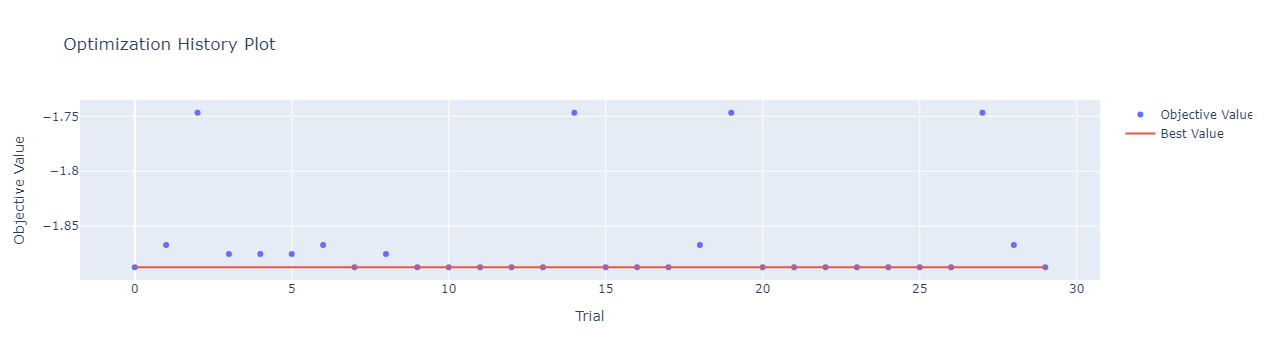

In [9]:
optuna.visualization.plot_optimization_history(study)

In this execution, since there are only four possible adsorption sites to search for, it can be seen that the fcc structure is found in the first trial.

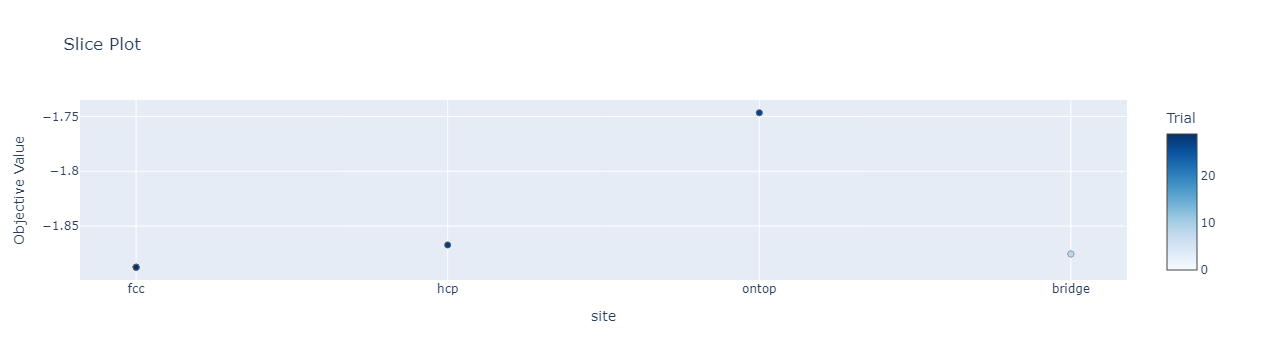

In [10]:
optuna.visualization.plot_slice(study)

Among the four adsorption sites, it can be seen that the fcc structure is the most energetically stable.

## Example: Adsorption Structure Search (Slightly Complex Version)

In the above example, we explained how to use Optuna for adsorption structure search with a simple example of finding which of the four adsorption sites is the most stable. Here, as a slightly more complex example, let's try searching for stable adsorption structures by searching the position (coordinates and rotation) of the adsorbing molecule (center of mass) before the adsorption reaction. First, let's prepare a utility function for converting a structure to a string.

In [11]:
import io

def atoms_to_json(atoms):
    f = io.StringIO()
    write(f, atoms, format="json")
    return f.getvalue()


def json_to_atoms(atoms_str):
    return read(io.StringIO(atoms_str), format="json")

Using the above functions, `Atoms` can be saved as a string and restored from a string to `Atoms`.

In [12]:
mol_json_str = atoms_to_json(mol)
mol2 = json_to_atoms(mol_json_str)

print(f"{mol_json_str=}")
view_ngl(mol2, representations=["ball+stick"])

mol_json_str='{"1": {\n "calculator": "asecalculator",\n "calculator_parameters": {},\n "cell": {"__ndarray__": [[3, 3], "float64", [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]},\n "ctime": 23.488978156630242,\n "mtime": 23.488978156630242,\n "numbers": {"__ndarray__": [[2], "int64", [8, 6]]},\n "pbc": {"__ndarray__": [[3], "bool", [false, false, false]]},\n "positions": {"__ndarray__": [[2, 3], "float64", [0.0, 0.0, 0.48941706312793415, 0.0, 0.0, -0.6537510631279342]]},\n "unique_id": "3cd9f156660ebd0b61a8e72e9187c6bc",\n "user": null},\n"ids": [1],\n"nextid": 2}\n'


Below is the optimization code using Optuna. First, let's look at the process after creating the `Study`.
```
study = optuna.create_study()

slab, E_slab = create_slab()
study.set_user_attr("slab", atoms_to_json(slab))
study.set_user_attr("E_slab", E_slab)

mol, E_mol = create_mol()
study.set_user_attr("mol", atoms_to_json(mol))
study.set_user_attr("E_mol", E_mol)
```
In the previous example, the surface structure and adsorbing molecule were created and locally optimized for each trial, but this does not need to be done every time. Therefore, before calling the optimization process (`Study.optimize`), the surface structure and adsorbing molecule are created and saved in the `user_attrs` of the `Study`. At that time, the `atoms_to_json` function is used to convert the `Atoms` object to a string in JSON format.

Next, let's look at the changes to the `objective` function. First, the saved surface structure and adsorbing molecule are restored from the `Trial`. At that time, the `json_to_atoms` function is used to convert the string in JSON format to an `Atoms` object.

Also, searching the position of the center of mass of the adsorbing molecule before the reaction will be as follows. The rotation around the origin is specified by [Euler angles](https://ja.wikipedia.org/wiki/%E3%82%AA%E3%82%A4%E3%83%A9%E3%83%BC%E8%A7%92) (`phi`, `theta`, `psi`), and the position of the center of mass is specified by xyz coordinates (`x_pos`, `y_pos`, `z_hig`). To avoid degeneracy in angles, `theta` is transformed to be between 0° and 180°.

Furthermore, in each trial, the adsorption structure after local optimization is saved in Optuna's storage so that it can be referred to later.
```
trial.set_user_attr("structure", atoms_to_json(slab))
```
By default, this storage is created in memory, so it will be lost when the notebook instance is closed. If you want to persist it to a file or RDB, specify the `storage` argument appropriately when creating the `Study` object. ([Reference](https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/001_rdb.html#sphx-glr-tutorial-20-recipes-001-rdb-py))

In [12]:
def objective(trial):
    slab = json_to_atoms(trial.study.user_attrs["slab"])
    E_slab = trial.study.user_attrs["E_slab"]
    
    mol = json_to_atoms(trial.study.user_attrs["mol"])
    E_mol = trial.study.user_attrs["E_mol"]
    
    phi = 180. * trial.suggest_float("phi", -1, 1)
    theta = np.arccos(trial.suggest_float("theta", -1, 1))*180./np.pi
    psi = 180 * trial.suggest_float("psi", -1, 1)
    x_pos = trial.suggest_float("x_pos", 0, 0.5)
    y_pos = trial.suggest_float("y_pos", 0, 0.5)
    z_hig = trial.suggest_float("z_hig", 1, 5)
    xy_position=np.matmul([x_pos,y_pos,0], slab.cell)[:2]
    mol.euler_rotate(phi=phi, theta=theta, psi=psi)
    
    add_adsorbate(slab, mol, z_hig, xy_position)
    E_slab_mol = get_opt_energy(slab, fmax=1e-3)
    
    trial.set_user_attr("structure", atoms_to_json(slab))
    
    return E_slab_mol - E_slab - E_mol

study = optuna.create_study()

slab, E_slab = create_slab()
study.set_user_attr("slab", atoms_to_json(slab))
study.set_user_attr("E_slab", E_slab)

mol, E_mol = create_mol()
study.set_user_attr("mol", atoms_to_json(mol))
study.set_user_attr("E_mol", E_mol)

study.optimize(objective, n_trials=30)
print(f"Best trial is #{study.best_trial.number}")
print(f"    Its adsorption energy is {study.best_value}")
print(f"    Its adsorption position is")
print(f"        phi  : {study.best_params['phi']}")
print(f"        theta: {study.best_params['theta']}")
print(f"        psi. : {study.best_params['psi']}")
print(f"        x_pos: {study.best_params['x_pos']}")
print(f"        y_pos: {study.best_params['y_pos']}")
print(f"        z_hig: {study.best_params['z_hig']}")

[I 2023-06-22 07:52:43,315] A new study created in memory with name: no-name-05c9ff48-36df-4154-a4ec-acdfc79af33b
[I 2023-06-22 07:52:53,632] Trial 0 finished with value: -1.7466693015211998 and parameters: {'phi': 0.673261826542781, 'theta': -0.08145613400482099, 'psi': 0.012660177285633178, 'x_pos': 0.21368073140208993, 'y_pos': 0.083302211884698, 'z_hig': 2.1579626406916224}. Best is trial 0 with value: -1.7466693015211998.
[I 2023-06-22 07:53:08,445] Trial 1 finished with value: -1.7466758266902556 and parameters: {'phi': 0.9855222409325082, 'theta': 0.016492100447592195, 'psi': 0.05601268852436658, 'x_pos': 0.2690629423392075, 'y_pos': 0.17557497446318515, 'z_hig': 3.0864597917564565}. Best is trial 1 with value: -1.7466758266902556.
[I 2023-06-22 07:53:15,151] Trial 2 finished with value: -1.7466824375789596 and parameters: {'phi': -0.14582683865571022, 'theta': 0.7177929241649788, 'psi': -0.23399827718877608, 'x_pos': 0.2587606449599002, 'y_pos': 0.29965098318287636, 'z_hig': 2.

Best trial is #27
    Its adsorption energy is -1.887434014767626
    Its adsorption position is
        phi  : -0.1548418507612546
        theta: 0.5206345752720033
        psi. : 0.6195729275282571
        x_pos: 0.11781482121159434
        y_pos: 0.2287451486234747
        z_hig: 1.3347112513526806


Let's visualize the search process and the obtained structures. First, let's start with the visualization of the search process that we did earlier.

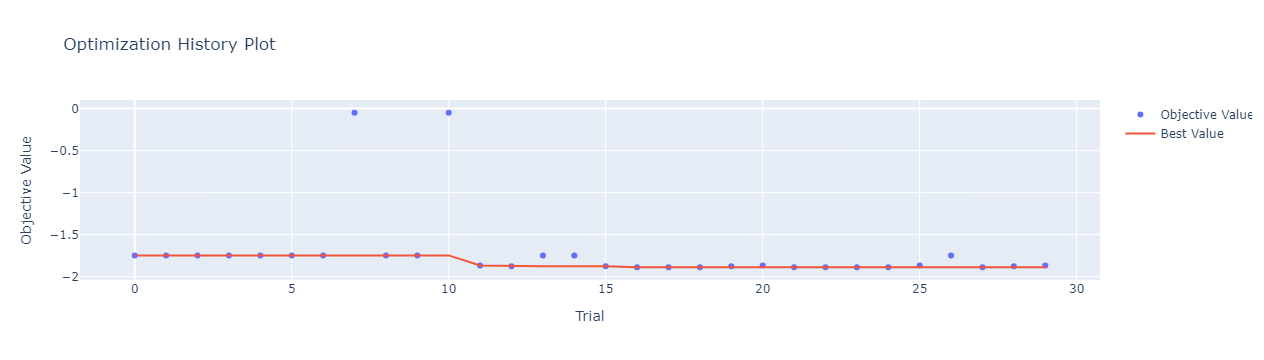

In [16]:
optuna.visualization.plot_optimization_history(study)

We can see that it converges in a few trials.

Also, let's visualize how each search parameter contributes to the adsorption energy.

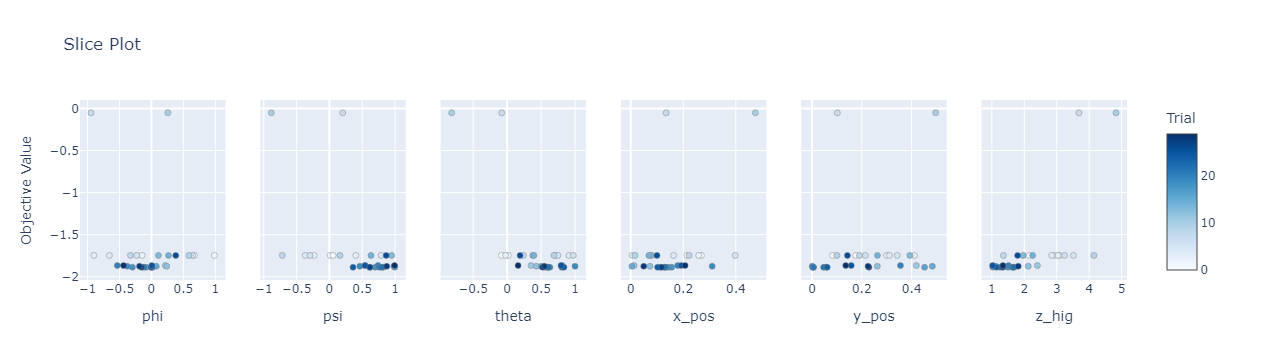

In [17]:
optuna.visualization.plot_slice(study)

For the angle parameters (`phi`, `theta`, `psi`), it can be seen that they are concentrated in:
- `phi`: `[0, 1]`
- `theta`: `[0, 1]`
- `psi`: `[-1, 0]`

Also, for the coordinate parameters (`x_pos`, `y_pos`, `z_hig`), it can be seen that they are concentrated in:
- `x_pos`: `[0, 0.2]`
- `y_pos`: `[0.2, 0.4]`
- `z_hig`: `[1, 3]`

Therefore, when continuing the search, if we limit the range of each parameter as follows:
```
phi = 180. * trial.suggest_float("phi", 0, 1)
theta = np.arccos(trial.suggest_float("theta", 0, 1))*180./np.pi
psi = 180 * trial.suggest_float("psi", -1, 0)
x_pos = trial.suggest_float("x_pos", 0, 0.2)
y_pos = trial.suggest_float("y_pos", 0.2, 0.4)
z_hig = trial.suggest_float("z_hig", 1, 3)
```
we can see that it may be possible to perform a more detailed search. In this way, by performing analysis using Optuna's visualization functions after searching for a certain number of trials, it is possible to improve the efficiency of subsequent searches.

Also, let's visualize the obtained structures. We saved the structures in the `user_attrs` of each trial, so we can retrieve them. 

In [18]:
slab = json_to_atoms(study.best_trial.user_attrs["structure"])
view_ngl(slab, representations=["ball+stick"])

Even though we searched by freely moving the position of the molecule, we can see that adsorption to the FCC site is indeed obtained as a stable adsorption structure.

Also, let's visualize and check the other structures that were tried during the search process.

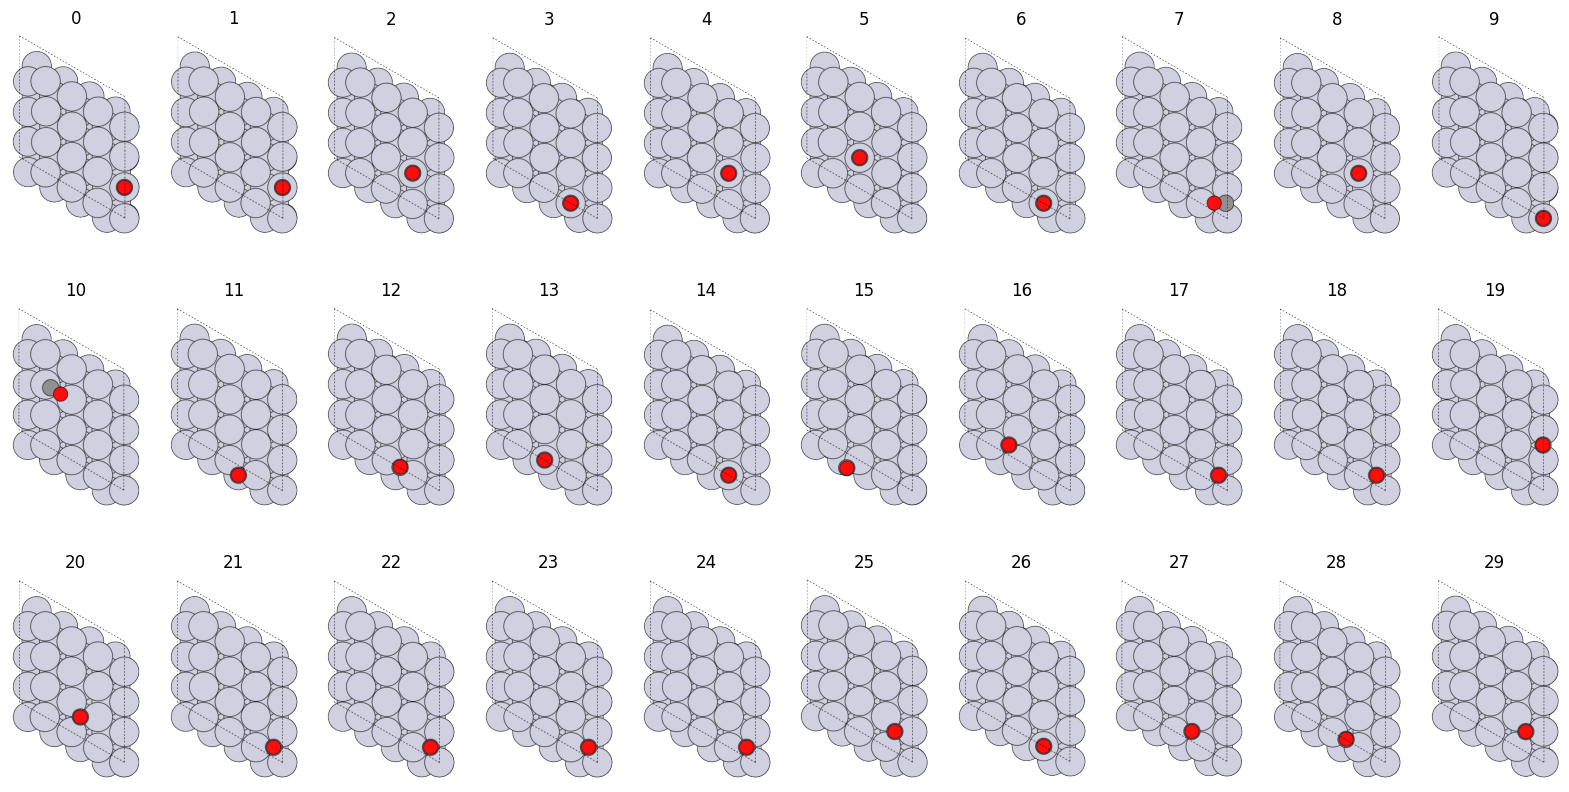

In [20]:
os.makedirs("output", exist_ok=True)

fig, axes = plt.subplots(len(study.trials) // 10, 10, figsize=(20, 10))
for trial in study.trials:
    slab = json_to_atoms(trial.user_attrs["structure"])
    write(f"output/{trial.number}.png", slab, rotation="0x,0y,90z")
    ax = axes[trial.number // 10][trial.number % 10]
    ax.imshow(mpimg.imread(f"output/{trial.number}.png"))
    ax.set_axis_off()
    ax.set_title(trial.number)
fig.show()

In this search, we randomly sampled 3D coordinates without utilizing prior knowledge about the symmetry of the adsorption sites, but we can see that the four adsorption sites were explored in the process. 

Finally, we also show a visualization using ngl_viewer so that each structure can be closely examined.

In [22]:
slabs = []
for trial in study.trials:
    slab = json_to_atoms(trial.user_attrs["structure"])
    slabs.append(slab)
view_ngl(slabs, representations=["ball+stick"], replace_structure=True)